# PSF Modeling Revisited

To model the PSF, I think the best way is to treat the PSF like a probably distribution such that, for each photon, we sample the probably distribution to determine the deviation in pixel position $\delta_x$ from the nominal pixel position $x_0$. In the absence of any PSF, this function should be a dirac delta function centered at $x=0$ such that the probably of zero deviation from the nominal position is 1. Additionally, the integral of this function over all $x$ must always be 1.

In [1]:
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np

from astropy.convolution.kernels import Gaussian1DKernel, Gaussian2DKernel

In [2]:
g = Gaussian1DKernel(3, mode='center', x_size=99)
position_variation = np.arange(*g.shape) - g.center + 0.5*(~g.shape[0]%2)

(-10.0, 10.0)

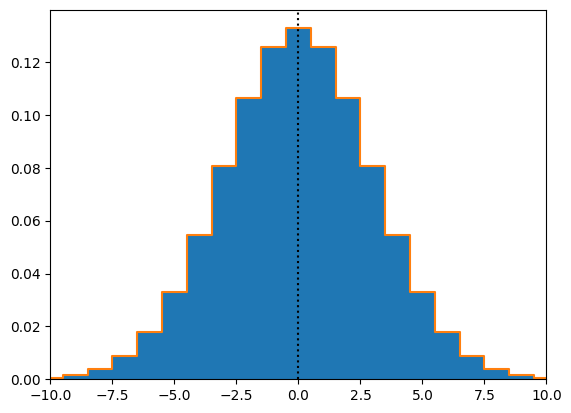

In [3]:
plt.step(position_variation, g.array, where='mid', color='C1')
plt.axvline(x=0, color='k', ls=':')
plt.hist(np.random.choice(position_variation, size=1000000, p=g.array),density=True,
         bins=np.arange(-10,12,1)-0.5)
plt.xlim(-10,10)

But what we really want is to do this in 2D

In [4]:
g2d = Gaussian2DKernel(1,10,mode='center')
x_variation = np.arange(g2d.shape[1]) - g2d.center[1] + 0.5*(~g2d.shape[1]%2)
y_variation = np.arange(g2d.shape[0]) - g2d.center[0] + 0.5*(~g2d.shape[0]%2)

In [5]:
x_variation_grid,y_variation_grid = np.meshgrid(x_variation,y_variation)

In [6]:
sample_indices = np.random.choice(g2d.array.size, size=10000, p=g2d.array.flatten())
sample_indices = np.unravel_index(sample_indices, g2d.shape)
sample_variations = np.array([x_variation_grid[sample_indices],
                              y_variation_grid[sample_indices]])

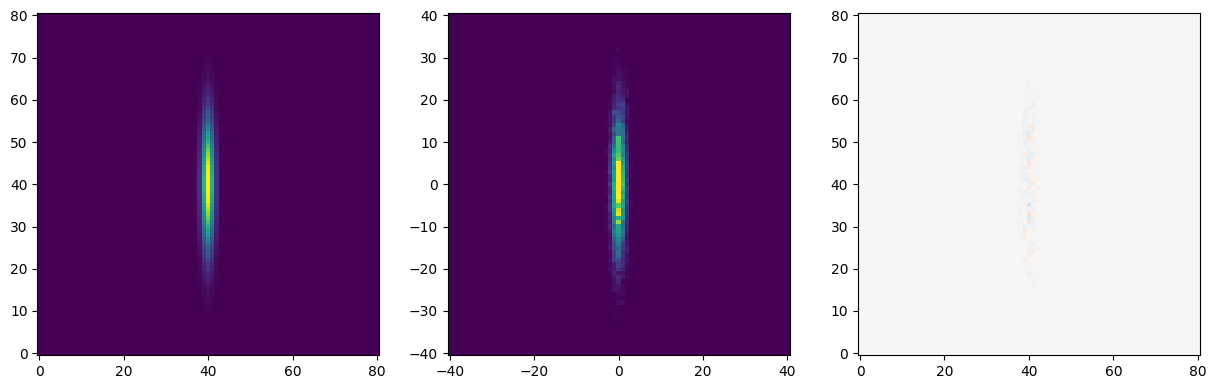

In [7]:
fig = plt.figure(figsize=(15,20))
ax = fig.add_subplot(131, aspect='equal')
im = ax.imshow(g2d,origin='lower',vmin=0,vmax=0.015)

ax = fig.add_subplot(132,aspect='equal')
res,_,_,_ = ax.hist2d(sample_variations[0],sample_variations[1],
           bins=(np.arange(x_variation[0],x_variation[-1]+2,1)-0.5,
                 np.arange(y_variation[0],y_variation[-1]+2,1)-0.5),
          density=True,
          vmin=0,vmax=0.015)
ax = fig.add_subplot(133, aspect='equal')
ax.imshow(g2d.array-res.T, origin='lower', vmin=-0.015, vmax=0.015, cmap='RdBu')

Now, let's try to build a kernel that more closely appoximates the MOXSI slot

First, define a function that does the sampling on any given kernel. The kernel is assumed to be defined on the detector plane.

In [8]:
def sample_psf_2d(kernel, n_samples, plot_kernel=False):
    """
    Sample a PSF to find the position variation for a number of incoming photons
    """
    x_variation = np.arange(kernel.shape[1]) - kernel.center[1] + 0.5*(~kernel.shape[1]%2)
    y_variation = np.arange(kernel.shape[0]) - kernel.center[0] + 0.5*(~kernel.shape[0]%2)
    x_variation_grid, y_variation_grid = np.meshgrid(x_variation,y_variation)
    sample_indices = np.random.choice(kernel.array.size, size=n_samples, p=kernel.array.flatten())
    sample_indices = np.unravel_index(sample_indices, kernel.shape)
    sample_variations = np.array([x_variation_grid[sample_indices], y_variation_grid[sample_indices]])
    if plot_kernel:
        fig = plt.figure(figsize=(15,20))
        ax = fig.add_subplot(131, aspect='equal')
        im = ax.imshow(kernel,origin='lower',vmin=0,vmax=0.015)
        ax = fig.add_subplot(132,aspect='equal')
        res,_,_,_ = ax.hist2d(sample_variations[0],sample_variations[1],
                              bins=(np.arange(x_variation[0],x_variation[-1]+2,1)-0.5,
                                    np.arange(y_variation[0],y_variation[-1]+2,1)-0.5),
                              density=True,
                              vmin=0,
                              vmax=0.015)
        ax.axvline(x=0, color='r', ls='--')
        ax.axhline(y=0, color='r', ls='--')
        ax = fig.add_subplot(133, aspect='equal')
        ax.imshow(kernel.array-res.T, origin='lower', vmin=-0.015, vmax=0.015, cmap='RdBu')
    else:
        return sample_variations

In [9]:
from astropy.modeling.models import Box2D
from astropy.convolution.kernels import Model2DKernel
from astropy.stats import gaussian_fwhm_to_sigma

from mocksipipeline.instrument.configuration import moxsi_slot

In [16]:
slot_width = moxsi_slot.channel_list[30].aperture.psf_fwhm[::-1] * gaussian_fwhm_to_sigma / moxsi_slot.optical_design.spatial_plate_scale
slot_width = slot_width.to_value('pixel')
slot_model = Box2D(1/(slot_width[0]*slot_width[1]), x_width=slot_width[0], y_width=slot_width[1])
slot_kernel = Model2DKernel(slot_model, x_size=int(5*slot_width[0]), y_size=int(2*slot_width[1]), mode='center')
slot_kernel.normalize()

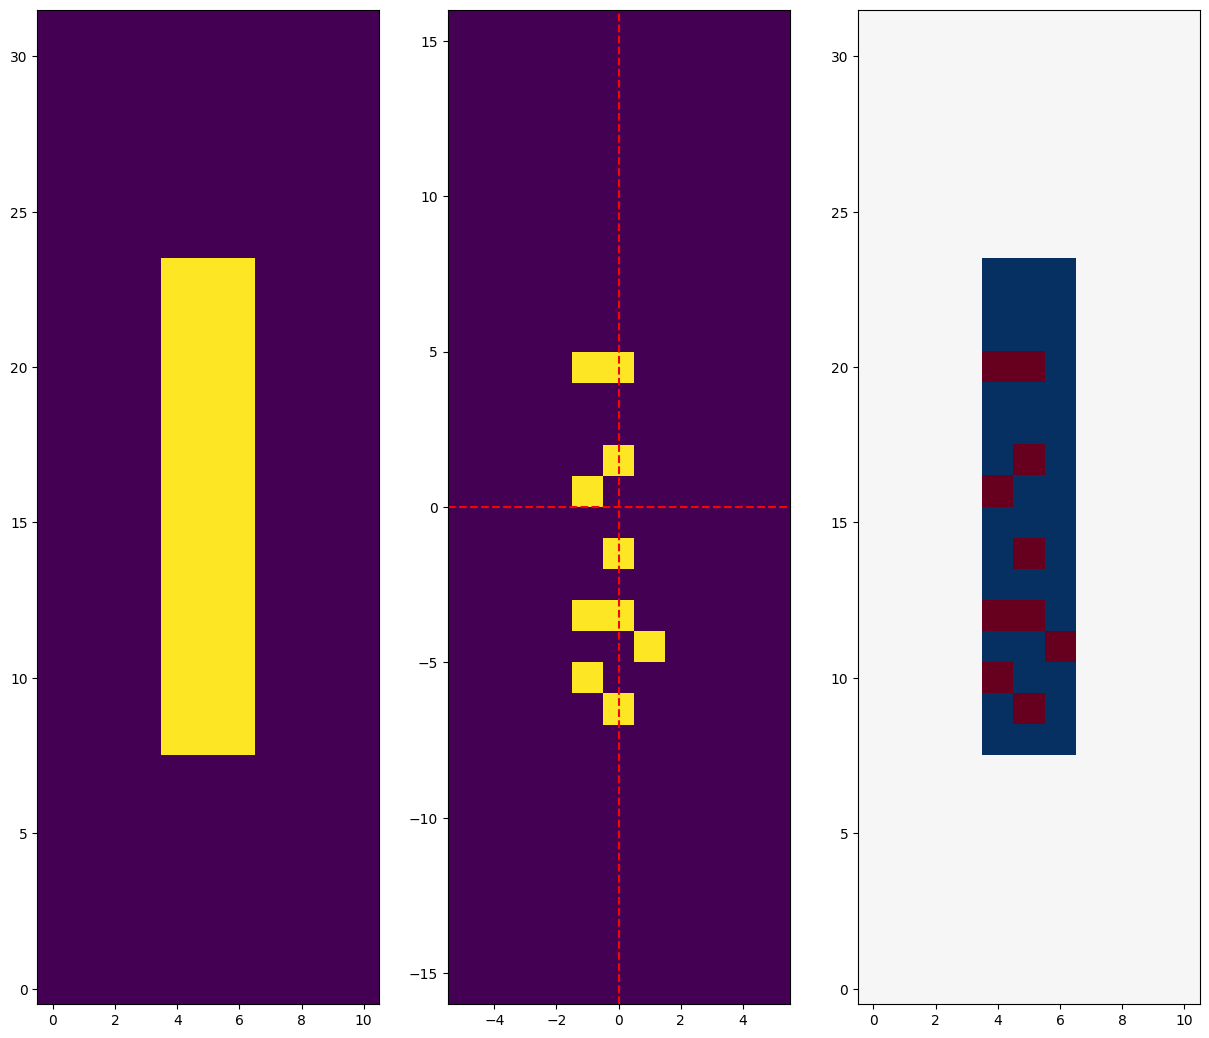

In [19]:
sample_psf_2d(slot_kernel, 10, plot_kernel=True)

Now we want to apply this same procedure but instead using the PSF kernel defined on the Channel object

In [35]:
for c in moxsi_slot.channel_list:
    print(c.name)

filtergram_1
filtergram_2
filtergram_3
filtergram_4
spectrogram_pinhole
spectrogram_pinhole
spectrogram_pinhole
spectrogram_pinhole
spectrogram_pinhole
spectrogram_pinhole
spectrogram_pinhole
spectrogram_pinhole
spectrogram_pinhole
spectrogram_pinhole
spectrogram_pinhole
spectrogram_pinhole
spectrogram_pinhole
spectrogram_pinhole
spectrogram_pinhole
spectrogram_pinhole
spectrogram_pinhole
spectrogram_pinhole
spectrogram_pinhole
spectrogram_pinhole
spectrogram_pinhole
spectrogram_pinhole
spectrogram_pinhole
spectrogram_slot
spectrogram_slot
spectrogram_slot
spectrogram_slot
spectrogram_slot
spectrogram_slot
spectrogram_slot
spectrogram_slot
spectrogram_slot
spectrogram_slot
spectrogram_slot
spectrogram_slot
spectrogram_slot
spectrogram_slot
spectrogram_slot
spectrogram_slot
spectrogram_slot
spectrogram_slot
spectrogram_slot
spectrogram_slot
spectrogram_slot
spectrogram_slot
spectrogram_slot


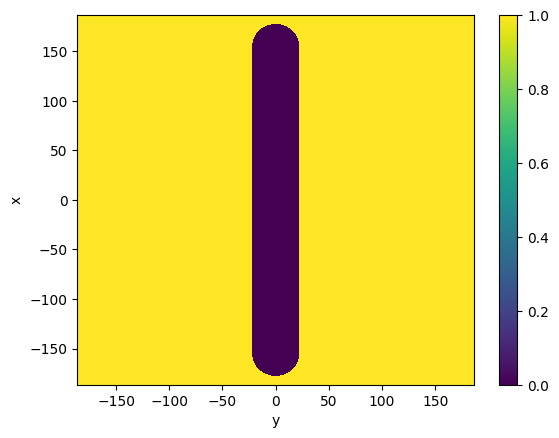

In [43]:
moxsi_slot['spectrogram_slot_-1'].aperture.mask().plot()

In [61]:
slot_psf = moxsi_slot['spectrogram_slot_-1'].psf(wavelength=10*u.AA)

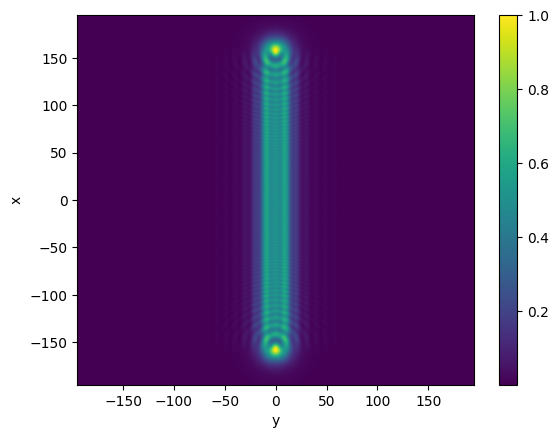

In [64]:
moxsi_slot['spectrogram_slot_-1'].psf(wavelength=20*u.AA)[0].plot()